In [1]:
import itertools
import pandas as pd
import numpy as np
from torch import nn
from typing import Optional
from module import report
from module import Data_Agument
from torch.utils.data import Dataset, DataLoader
from transformers.modeling_outputs import TokenClassifierOutput
from datasets import Dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import BertModel
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss,NLLLoss
import torch
from sklearn.model_selection import train_test_split
from livelossplot import PlotLosses
from tqdm.notebook import tqdm
from module import pytorchtools_Bert

label_list = [
'<pad>',
'O',
'B-RightSpeaker',   
'B-Speaker',
'B-LeftSpeaker',
'B-Unknown',
'I-RightSpeaker',
'I-Speaker',
'I-LeftSpeaker',
'I-Unknown',
"<EOS>",
"<BOS>"
]
label_encoding_dict = {
'<pad>':0,
'O': 1,
'B-RightSpeaker': 2,   
'B-Speaker': 3,
'B-LeftSpeaker': 4,
'B-Unknown': 5,
'I-RightSpeaker': 6,
'I-Speaker': 7,
'I-LeftSpeaker': 8,
'I-Unknown': 9,
"<EOS>":10,
"<BOS>":11
}
task = "ner" 
model_checkpoint = "bert-base-uncased"
batch_size = 32
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


def get_all_tokens_and_ner_tags(directory):
    return pd.concat([get_tokens_and_ner_tags(directory) ]).reset_index().drop('index', axis=1)


def get_tokens_and_ner_tags(filename):
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        split_list = [list(y) for x, y in itertools.groupby(lines, lambda z: z == '\n') if not x]
        tokens = [[x.split(' ')[0] for x in y] for y in split_list]
        entities = [[x.split(' ')[1][:-1] for x in y] for y in split_list] 
    return pd.DataFrame({'tokens': tokens, 'ner_tags': entities})


def get_un_token_dataset(directory, Rondom):
    if Rondom:
        df, AFTER_NAME_LIST_APPEAR_1, AFTER_NAME_LIST__OVER_1 = Data_Agument.get_Data_Agument(directory)
        print(len(AFTER_NAME_LIST_APPEAR_1), len(AFTER_NAME_LIST__OVER_1))
    else:
        df = get_all_tokens_and_ner_tags(directory)
        for i in range(len(df)):
            df.ner_tags[i] = ["O" if d == "Out" else d for d in df.ner_tags[i]]

    df_train, df_test = train_test_split(df, test_size=0.3)
    df_test, df_val = train_test_split(df_test, test_size=0.5)
    test_dataset = Dataset.from_pandas(df_test.reset_index(drop=True))
    train_dataset = Dataset.from_pandas(df_train.reset_index(drop=True))
    val_dataset = Dataset.from_pandas(df_val.reset_index(drop=True))

    return (df,train_dataset,test_dataset,val_dataset)

In [2]:
df, train_dataset, test_dataset, val_dataset = get_un_token_dataset("./DirectQuote/data/truecased.txt",True)

884 1776


In [3]:
path_checkpoint = 'path/model_B_BiL_path.pth'
path_model = "model_bert/BL_CRF.pth"

In [4]:
def tokenize_and_align_labels(examples):
    label_all_tokens = True
    tokenized_inputs = tokenizer(list(examples["tokens"]), truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        EOS_check=True
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None and EOS_check is True:
                label_ids.append(10)
                EOS_check=False
            elif word_idx is None and EOS_check is False:
                label_ids.append(11)
            elif word_idx != previous_word_idx:
                label_ids.append(label_encoding_dict[label[word_idx]])
            else:
                label_ids.append(label_encoding_dict[label[word_idx]] if label_all_tokens else -101)
            previous_word_idx = word_idx
        labels.append(label_ids)
        
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [5]:
train_tokenized_datasets = train_dataset.map(tokenize_and_align_labels, batched=True)
test_tokenized_datasets = test_dataset.map(tokenize_and_align_labels, batched=True)
val_tokenized_datasets = val_dataset.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [6]:
class CreateDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, index):
        input_ids = torch.tensor(self.dataset[index]["input_ids"])
        token_type_ids = torch.tensor(self.dataset[index]["token_type_ids"])
        attention_mask = torch.tensor(self.dataset[index]["attention_mask"])
        labels = torch.tensor(self.dataset[index]["labels"])
        return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_mask,
        "labels": labels
        }

In [7]:
def collate_batch(batch):
    label_list, text_list,M_list,type_list = [], [],[],[]
    for (B) in batch:
        _text=B["input_ids"]
        _label=B["labels"]
        _mask=B["attention_mask"]
        _type=B["token_type_ids"]
        label_list.append(_label)
        text_list.append(_text)
        M_list.append(_mask)
        type_list.append(_type)
    text_list = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=0)
    label_list = torch.nn.utils.rnn.pad_sequence(label_list, batch_first=True, padding_value=0)
    M_list = torch.nn.utils.rnn.pad_sequence(M_list, batch_first=True, padding_value=0)
    type_list = torch.nn.utils.rnn.pad_sequence(type_list, batch_first=True, padding_value=0)
    return {
        "input_ids": text_list,
        "token_type_ids": type_list,
        "attention_mask": M_list,
        "labels": label_list
        }

In [8]:
dataset_train_for_loader = CreateDataset(train_tokenized_datasets)
dataset_val_for_loader = CreateDataset(val_tokenized_datasets)
dataset_test_for_loader = CreateDataset(test_tokenized_datasets)


dataloader_train = DataLoader(
    dataset_train_for_loader,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    collate_fn=collate_batch
)
dataloader_val = DataLoader(
    dataset_val_for_loader,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    collate_fn=collate_batch
)
dataloader_test = DataLoader(
    dataset_test_for_loader,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    collate_fn=collate_batch
)
dataloaders_dict = {"train": dataloader_train, "val": dataloader_val}

In [9]:
from transformers import BertConfig
config = BertConfig()
config.num_labels = len(label_list)
print(config.initializer_range)

0.02


In [10]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()
        self.num_labels = config.num_labels

        self.bert = BertModel.from_pretrained(model_checkpoint,add_pooling_layer=False, output_attentions=True, output_hidden_states=True)

    def forward(
        self,
        input_ids,
        token_type_ids,
        attention_mask,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
        ):
      
        return_dict = return_dict if return_dict is not None else config.use_return_dict
        outputs = self.bert(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            return_dict=return_dict,
        )
    
        return TokenClassifierOutput(
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [11]:
class BERT_BiLSTM(nn.Module):
    def __init__(self, config, batch_size, device):
        super(BERT_BiLSTM, self).__init__()
        self.num_labels = config.num_labels
        self.hidden_size = config.hidden_size
        self.batch_size = batch_size
        self.device = device
        self.dropout = torch.nn.Dropout(0.3)
        self.bert = BERT()
        self.BiLSTM = nn.LSTM(input_size=self.hidden_size,
                              hidden_size=self.hidden_size,
                              batch_first=True,
                              bidirectional=True)
        self.hidden2label = nn.Linear(self.hidden_size*2, self.num_labels)

    def _get_bert_features(self, input_ids, token_type_ids, attention_mask, labels, return_dict):
        bert_seq_out = self.bert(
            input_ids=input_ids, 
            token_type_ids=None,
            attention_mask=attention_mask, 
            labels=labels,
            return_dict=True)
        bert_seq_out = self.dropout(bert_seq_out["hidden_states"][-1])
        bilstm_seq_out, _ = self.BiLSTM(bert_seq_out, None)
        bilstm_seq_out = self.dropout(bilstm_seq_out)
        bert_bilstm_feats = self.hidden2label(bilstm_seq_out)
        return bert_bilstm_feats

    def forward(self, input_ids, token_type_ids, attention_mask, labels, return_dict):

        bert_bilstm_feats = self._get_bert_features(
            input_ids=input_ids, 
            token_type_ids=None,
            attention_mask=attention_mask, 
            labels=labels,
            return_dict=True)
        loss_fct = CrossEntropyLoss(ignore_index=0)
        loss = loss_fct(bert_bilstm_feats.view(-1, self.num_labels), labels.view(-1))
        return TokenClassifierOutput(
            loss=loss,
            logits=bert_bilstm_feats,
        )

In [12]:
label_list = label_list
label_map = {label: i for i,label in enumerate(label_list)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
start_label_id = label_map["<BOS>"]
stop_label_id = label_map["<EOS>"]
model = BERT_BiLSTM(config, batch_size, device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'bert.pooler.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
model_params = list(model.named_parameters())

In [15]:
bert_params = [p for n, p in model_params if "bert" in n]
class_params = [p for n, p in model_params if "hidden2label" in n]
lstm_params = [p for n, p in model_params if "BiLSTM" in n] 
params = [
    {'params': bert_params, 'lr': 0.00001},
    {'params': lstm_params, 'lr': 0.0001,'weight_decacy_rate':0.00001},
    {'params': class_params, 'lr': 0.001}
]

for param in model.parameters():
    param.requires_grad = False

for param in model.bert.bert.encoder.layer[-8:].parameters():
    param.requires_grad = True
    
for param in model.BiLSTM.parameters():
    param.requires_grad = True 
for param in model.hidden2label.parameters():
    param.requires_grad = True 

In [16]:
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
patience = 10
early_stopping = pytorchtools_Bert.EarlyStopping(patience=patience, verbose=True,path=path_checkpoint)
model.to(device)
liveloss = PlotLosses()
optimizer = torch.optim.Adam(params)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma=0.1)
def train_model(net, dataloaders_dict, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')

    net.to(device)

    torch.backends.cudnn.benchmark = True

    batch_size = dataloaders_dict["train"].batch_size
    logs = {}
    lrs = []
    for epoch in range(num_epochs):
        print(epoch)

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()

            epoch_loss = 0.0
            L2,P2=[],[]

            for batch in tqdm((dataloaders_dict[phase])):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    output = net(input_ids=input_ids,
                                 token_type_ids=None,
                                 attention_mask=attention_mask,
                                 labels=labels,
                                 return_dict=True)
                    loss = output[0]
                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
                        optimizer.step()
                    epoch_loss += loss.item()*batch_size
            if phase == 'val':
                logs['val_loss'] = epoch_loss/ len(dataloaders_dict[phase].dataset)
            else:
                logs['loss'] = epoch_loss/ len(dataloaders_dict[phase].dataset)
        if phase == 'val':
            early_stopping(epoch_loss/ len(dataloaders_dict[phase].dataset),net) 
            if early_stopping.early_stop:
                print("Early Stopping")
                return net
        liveloss.update(logs)
        liveloss.send()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        plt.plot(lrs)
        plt.show()


    return net

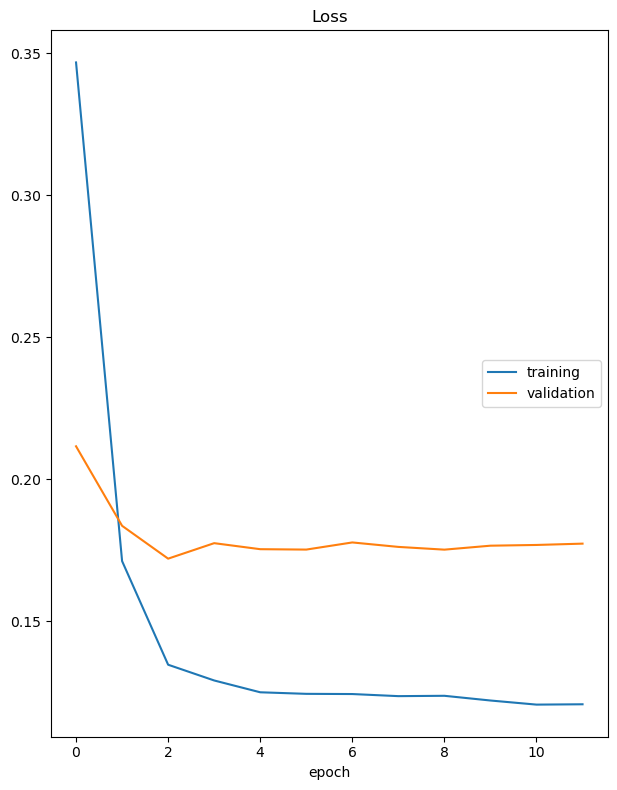

Loss
	training         	 (min:    0.121, max:    0.347, cur:    0.121)
	validation       	 (min:    0.172, max:    0.212, cur:    0.177)


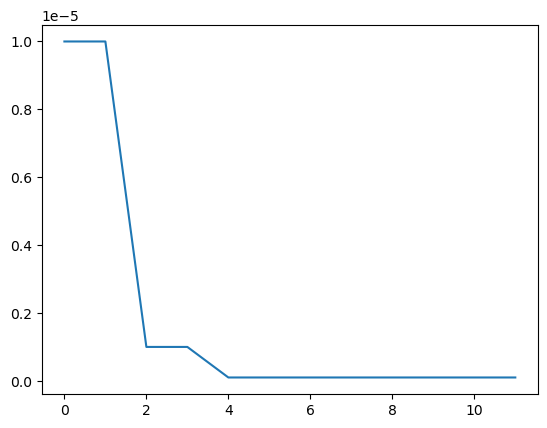

12


  0%|          | 0/427 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

EarlyStopping counter: 10 out of 10
Early Stopping


In [17]:
num_epochs = 30
net_trained = train_model(model, dataloaders_dict, num_epochs=num_epochs)

In [19]:
from torchcrf import CRF
CRF(len(label_list), batch_first=True)._viterbi_decode

<bound method CRF._viterbi_decode of CRF(num_tags=12)>

In [20]:
def DATA_CLEAN(out, mask):
    pre = [label_list[out[i + 1]] for i in range(sum(mask > 0) - 2)]
    return (report.get_entities(pre), pre)


def evaluate_model(batch_entities_list, batch_entities_predicted_list, type_id=None):
    num_entities = 0
    num_predictions = 0
    num_correct = 0 
    for entities_list, entities_predicted_list in zip(batch_entities_list, batch_entities_predicted_list):
        for entities, entities_predicted in zip(entities_list, entities_predicted_list):
            if type_id:
                entities = [e for e in entities if e[0] == type_id]
                entities_predicted = [
                    e for e in entities_predicted if e[0] == type_id
                ]

            get_span_type = lambda e: (e[1], e[2], e[0])
            set_entities = set(get_span_type(e) for e in entities)
            set_entities_predicted = set(get_span_type(e) for e in entities_predicted)
            num_entities += len(entities)
            num_predictions += len(entities_predicted)
            num_correct += len(set_entities & set_entities_predicted)

    precision = num_correct/num_predictions
    recall = num_correct/num_entities
    f_value = 2*precision*recall/(precision+recall)

    result = {
        'num_entities': num_entities,
        'num_predictions': num_predictions,
        'num_correct': num_correct,
        'precision': precision,
        'recall': recall,
        'f_value': f_value
    }

    return result


def eval_model(label, lists):
    eval_label_encoding_dict = {
        "Speaker": "Speaker",
        "Quoat": "Quoat"
    }
    eval_df = pd.DataFrame()
    for k, v in eval_label_encoding_dict.items():
        eval_res = evaluate_model(label, lists, type_id=v)
        eval_df[k] = eval_res.values()

    eval_res_all = evaluate_model(label, lists, type_id=None)
    eval_df["ALL"] = eval_res_all.values()

    eval_df.index = eval_res_all.keys()
    return eval_df


def mat3(datasets, MO):
    crf=CRF(len(label_list), batch_first=True)
    tran=np.array([
    [0,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1],
    [0,0,0,0,0,0,-1,-1,-1,-1,0,-1],
    [0,0,0,0,0,0,0,-1,-1,-1,0,-1],
    [0,0,0,0,0,0,-1,0,-1,-1,0,-1],
    [0,0,0,0,0,0,-1,-1,0,-1,0,-1],
    [0,0,0,0,0,0,-1,-1,-1,0,0,-1],
    [0,0,0,0,0,0,0,-1,-1,-1,0,-1],
    [0,0,0,0,0,0,-1,0,-1,-1,0,-1],
    [0,0,0,0,0,0,-1,-1,0,-1,0,-1],
    [0,0,0,0,0,0,-1,-1,-1,0,0,-1],
    [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
    [-1,0,0,0,0,0,-1,-1,-1,-1,-1,-1]
    ], dtype='float64')
    tran[tran == -1] = -0.1
    crf.transitions=nn.Parameter(torch.tensor(tran))
    L2, P2 = [], []
    MO.eval()
    MO.to(device)
    with torch.no_grad():
        for batch in tqdm((datasets)):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            output = MO(input_ids=input_ids, token_type_ids=None, 
                        attention_mask=attention_mask, 
                        labels=labels,
                        return_dict=True)
            preT = crf.decode(output.logits.to("cpu"), attention_mask.bool().to("cpu"))
            out_list = map(DATA_CLEAN,
                                preT,
                                attention_mask.cpu().numpy().copy())
            out_label = map(DATA_CLEAN,
                                 labels,
                                 attention_mask.cpu().numpy().copy())
            #print([pd.DataFrame({'pre': p[1], 'true': l[1]}) for p, l in zip(list(out_list), list(out_label))])
            P2.append([o[0] for o in list(out_list)])
            L2.append([o[0] for o in list(out_label)])


    return L2, P2, eval_model(L2, P2)

In [21]:
L, P, eval_result= mat3(dataloader_test, torch.load(path_checkpoint))

[[ 0.  -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1  0.  -0.1]
 [ 0.   0.   0.   0.   0.   0.  -0.1 -0.1 -0.1 -0.1  0.  -0.1]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.1 -0.1 -0.1  0.  -0.1]
 [ 0.   0.   0.   0.   0.   0.  -0.1  0.  -0.1 -0.1  0.  -0.1]
 [ 0.   0.   0.   0.   0.   0.  -0.1 -0.1  0.  -0.1  0.  -0.1]
 [ 0.   0.   0.   0.   0.   0.  -0.1 -0.1 -0.1  0.   0.  -0.1]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.1 -0.1 -0.1  0.  -0.1]
 [ 0.   0.   0.   0.   0.   0.  -0.1  0.  -0.1 -0.1  0.  -0.1]
 [ 0.   0.   0.   0.   0.   0.  -0.1 -0.1  0.  -0.1  0.  -0.1]
 [ 0.   0.   0.   0.   0.   0.  -0.1 -0.1 -0.1  0.   0.  -0.1]
 [-0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1]
 [-0.1  0.   0.   0.   0.   0.  -0.1 -0.1 -0.1 -0.1 -0.1 -0.1]]


  0%|          | 0/92 [00:00<?, ?it/s]

In [22]:
eval_model(L, P)

,Speaker,Quoat,ALL
num_entities,1087.000000,785.000000,1872.000000
num_predictions,1260.000000,876.000000,2136.000000
num_correct,1034.000000,664.000000,1698.000000
precision,0.820635,0.757991,0.794944
recall,0.951242,0.845860,0.907051
f_value,0.881125,0.799518,0.847305


In [23]:
eval_model(L, P)

,Speaker,Quoat,ALL
num_entities,1087.000000,785.000000,1872.000000
num_predictions,1260.000000,876.000000,2136.000000
num_correct,1034.000000,664.000000,1698.000000
precision,0.820635,0.757991,0.794944
recall,0.951242,0.845860,0.907051
f_value,0.881125,0.799518,0.847305
